# Example notebook for analyzing SASSIE model output

2024-04-24
Ian Fenty


Requires SASSIE AWS credentials stored in ~/.aws/credentials


In [34]:
from datetime import datetime
import boto3
from dask.distributed import Client
import fsspec
from glob import glob
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import requests
import subprocess
import s3fs
import time
from tqdm import tqdm
import ujson
import xarray as xr

%matplotlib inline


# Connect Dask Client

In [2]:
from dask.distributed import Client
try:
    client.close()
except Exception as e:
    print(e)


name 'client' is not defined


In [3]:
client = Client("tcp://127.0.0.1:44635")
client

<Client: 'tcp://127.0.0.1:44635' processes=8 threads=32, memory=123.94 GiB>

# Preliminaries 

## Download kerchunk jsons from s3
```$ cd ~```

```$ aws s3 sync s3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/jsons jsons --profile sassie```
/home/jpluser/efs-mount-point/example_sassie_netcdfs/jsons


## Connect to SASSIE S3 bucket

### get sassie credentials

In [44]:
s3_options = dict(anon=False, key=credentials.access_key, secret=credentials.secret_key)
s3 = s3fs.S3FileSystem(**s3_options)

## Load SASSIE Grid file

### copy grid file from S3 to local machine

```$ aws s3 cp s3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.nc GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.nc --profile sassie```

### Load SASSIE Grid

In [30]:
sg = xr.open_dataset('/home/jpluser/efs-mount-point/example_sassie_netcdfs/GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.nc')
sg.load()

<xarray.Dataset> Size: 5GB
Dimensions:  (j: 1080, i: 1800, j_g: 1080, i_g: 1800, k_p1: 91, k: 90, k_u: 90,
              k_l: 90, nb: 4, nv: 2)
Coordinates: (12/19)
  * i        (i) int32 7kB 0 1 2 3 4 5 6 ... 1793 1794 1795 1796 1797 1798 1799
  * i_g      (i_g) int32 7kB 0 1 2 3 4 5 6 ... 1794 1795 1796 1797 1798 1799
  * j        (j) int32 4kB 0 1 2 3 4 5 6 ... 1073 1074 1075 1076 1077 1078 1079
  * j_g      (j_g) int32 4kB 0 1 2 3 4 5 6 ... 1074 1075 1076 1077 1078 1079
  * k        (k) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
    ...       ...
    Zp1      (k_p1) float32 364B 0.0 -1.0 -2.14 ... -6.082e+03 -6.52e+03 -7e+03
    Zu       (k_u) float32 360B -1.0 -2.14 -3.44 ... -6.082e+03 -6.52e+03 -7e+03
    Zl       (k_l) float32 360B 0.0 -1.0 -2.14 ... -6.082e+03 -6.52e+03
    XC_bnds  (j, i, nb) float32 31MB -128.1 -128.1 -128.0 ... 52.0 52.0 51.92
    YC_bnds  (j, i, nb) float32 31MB 48.7 48.65 48.65 48.7 ... 63.33 63.36 63.36
    Z_bnds   (k, nv) float32 720B 0.0 -1.0 -1.0 ... -6.52e+03 -6.52e+03 -7e+03
Dimensions without coordinates: nb, nv
Data variables: (12/21)
    CS       (j, i) float64 16MB 0.0 0.0 -6.473e-14 -6.473e-14 ... 0.0 0.0 0.0
    SN       (j, i) float64 16MB 1.0 1.0 1.0 1.0 1.0 ... -0.0 -0.0 -0.0 -0.0
    rAc      (j, i) float64 16MB 3.515e+07 3.509e+07 ... 1.336e+07 1.342e+07
    dxG      (j_g, i) float64 16MB 5.747e+03 5.741e+03 ... 3.498e+03 3.505e+03
    dyG      (j, i_g) float64 16MB 6.114e+03 6.108e+03 ... 3.825e+03 3.833e+03
    Depth    (j, i) float64 16MB 2.522e+03 2.531e+03 2.503e+03 ... 0.0 0.0 0.0
    ...       ...
    hFacC    (k, j, i) float64 1GB 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    hFacW    (k, j, i_g) float64 1GB 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    hFacS    (k, j_g, i) float64 1GB 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    maskC    (k, j, i) bool 175MB True True True True ... False False False
    maskW    (k, j, i_g) bool 175MB True True True True ... False False False
    maskS    (k, j_g, i) bool 175MB True True True True ... False False False
Attributes: (12/58)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Mike Wood, Marie Zahn, and Ian Fenty
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    references:                      TBD
    source:                          The SASSIE ocean model simulation was pr...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           SASSIE Ocean Model Geometry Parameters f...
    uuid:                            85e78ca0-e7f6-11ee-ad4d-aa598f4e49fc

Text(0.5, 1.0, 'depth')

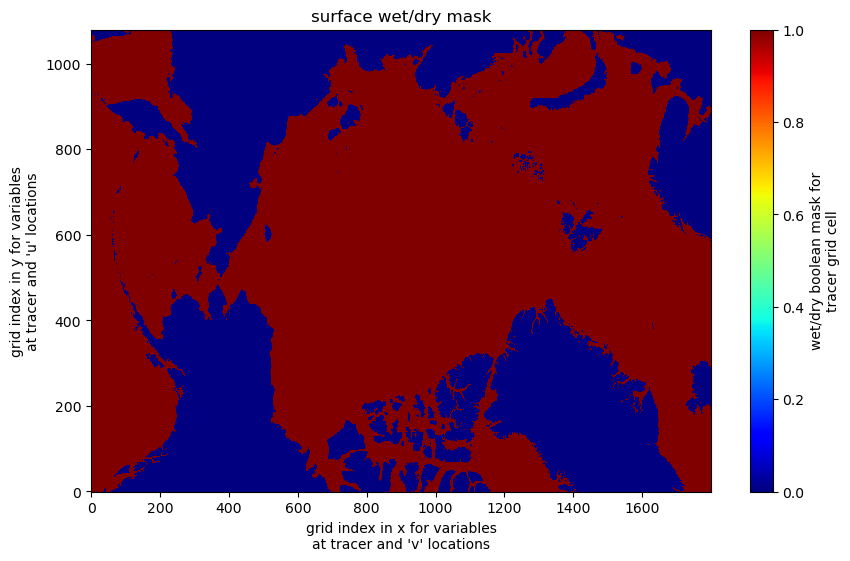

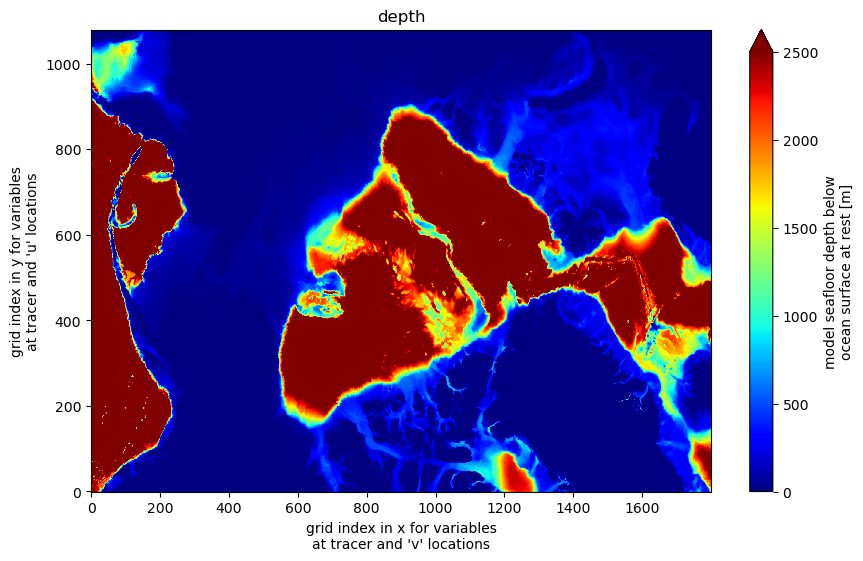

In [32]:
plt.figure(figsize=[10,6]);
sg.maskC.isel(k=0).plot(vmin=0,vmax=1, cmap='jet')
plt.title('surface wet/dry mask');
plt.figure(figsize=[10,6]);
sg.Depth.plot(vmin=0,vmax=2500, cmap='jet')
plt.title('depth');

# Load Kerchunked Datasets


In [99]:
local_json_path = Path('/home/jpluser/jsons')
json_files = np.sort(list(local_json_path.glob('*json')))

# show all json files
for j, jf in enumerate(json_files):
    print(j, jf)

0 /home/jpluser/jsons/ADVr_SLT_AVG_DAILY.json
1 /home/jpluser/jsons/ADVr_TH_AVG_DAILY.json
2 /home/jpluser/jsons/ADVxHEFF_AVG_DAILY.json
3 /home/jpluser/jsons/ADVxSNOW_AVG_DAILY.json
4 /home/jpluser/jsons/ADVx_SLT_AVG_DAILY.json
5 /home/jpluser/jsons/ADVx_TH_AVG_DAILY.json
6 /home/jpluser/jsons/ADVyHEFF_AVG_DAILY.json
7 /home/jpluser/jsons/ADVySNOW_AVG_DAILY.json
8 /home/jpluser/jsons/ADVy_SLT_AVG_DAILY.json
9 /home/jpluser/jsons/ADVy_TH_AVG_DAILY.json
10 /home/jpluser/jsons/DFrE_SLT_AVG_DAILY.json
11 /home/jpluser/jsons/DFrE_TH_AVG_DAILY.json
12 /home/jpluser/jsons/DFrI_SLT_AVG_DAILY.json
13 /home/jpluser/jsons/DFrI_TH_AVG_DAILY.json
14 /home/jpluser/jsons/DFxE_SLT_AVG_DAILY.json
15 /home/jpluser/jsons/DFxE_TH_AVG_DAILY.json
16 /home/jpluser/jsons/DFyE_SLT_AVG_DAILY.json
17 /home/jpluser/jsons/DFyE_TH_AVG_DAILY.json
18 /home/jpluser/jsons/ETAN_AVG_DAILY.json
19 /home/jpluser/jsons/EXFaqh_AVG_DAILY.json
20 /home/jpluser/jsons/EXFatemp_AVG_DAILY.json
21 /home/jpluser/jsons/EXFempmr_AVG_

In [133]:
def rechunk_ds(ds, time_chunk=1):
    for dv in ds.data_vars:
        print('rechunking ', dv)

        # 3D fields need chunking in space
        if len(ds[dv].dims) == 4:
            if 'k' in ds[dv].dims:
                ds[dv] = ds[dv].chunk({'time':time_chunk, 'k':23, 'j':270, 'i':450})
            if 'k_l' in ds[dv].dims:
                ds[dv] = ds[dv].chunk({'time':time_chunk, 'k_l':23, 'j':270, 'i':450})
        else:
            # 2D fields don't need rechunking in space
            ds[dv] = ds[dv].chunk({'time':time_chunk, 'j':1080, 'i':1800})
    return ds

In [134]:
def load_dataset_from_json(json_file, time_chunk=1):
    
    fs = fsspec.filesystem(
        "reference", 
        fo=json_file, 
        remote_protocol="s3", 
        remote_options=s3_options,
        skip_instance_cache=True
    )
    m = fs.get_mapper("")
    
    ds = xr.open_dataset(m, engine='zarr', consolidated=False)

    ds = rechunk_ds(ds, time_chunk=time_chunk)
    
    return ds
    

# Example calculations

Consider sea ice area (2D) and potential temperature (3D)

In [264]:
THETA_DS = load_dataset_from_json(str(json_files[54]),time_chunk=10)
SIarea_DS = load_dataset_from_json(str(json_files[46]),time_chunk=10)

rechunking  THETA
rechunking  SIarea


In [265]:
THETA_DS

<xarray.Dataset> Size: 4TB
Dimensions:    (time: 2579, k: 90, j: 1080, i: 1800, k_l: 90, k_p1: 91,
                k_u: 90, nv: 2)
Coordinates: (12/14)
    XC         (time, j, i) float32 20GB ...
    YC         (time, j, i) float32 20GB ...
    Z          (time, k) float32 928kB ...
    Zl         (time, k_l) float32 928kB ...
    Zp1        (time, k_p1) float32 939kB ...
    Zu         (time, k_u) float32 928kB ...
    ...         ...
  * k          (k) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k_l        (k_l) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k_p1       (k_p1) int32 364B 0 1 2 3 4 5 6 7 8 ... 83 84 85 86 87 88 89 90
  * k_u        (k_u) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * time       (time) datetime64[ns] 21kB 2014-01-15T12:00:00 ... 2021-02-07T...
    time_bnds  (time, nv) datetime64[ns] 41kB ...
Dimensions without coordinates: nv
Data variables:
    THETA      (time, k, j, i) float64 4TB dask.array<chunksize=(10, 23, 270, 450), meta=np.ndarray>
Attributes: (12/55)
    Conventions:                     CF-1.8, ACDD-1.3
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Mike Wood, Marie Zahn, and Ian Fenty
    cdm_data_type:                   Grid
    comment:                         SASSIE llc1080 V1R1 fields are consolida...
    creator_email:                   ecco-group@mit.edu
    ...                              ...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides data variable and ...
    time_coverage_end:               2014-01-15T00:00:00
    time_coverage_start:             2014-01-16T00:00:00
    title:                           SASSIE Ocean Model THETA Parameter for t...
    uuid:                            60d4c988-e9fd-11ee-8537-067436d4d101

## 2D field

### Variance of sea ice area

In [266]:
start_time = time.time()
# calculate variance of sea ice area over all time
SIarea_var = SIarea_DS.SIarea.var(dim='time').compute()
print(f'total time : {(time.time() - start_time):.2f}')

total time : 26.93


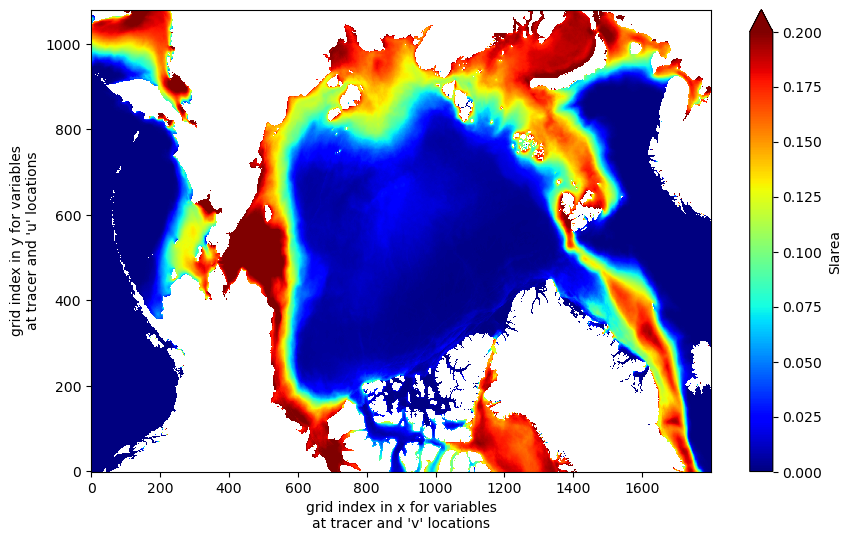

In [267]:
plt.figure(figsize=[10,6]);
SIarea_var.plot(cmap='jet',vmin=0,vmax=0.2)

### Time series of total sea ice area

In [268]:
start_time = time.time()

# grid cell area 
# ... note for some reason we have to drop XC and YC from the rAc grid cell area
rAc =  sg.rAc.drop_vars(['XC','YC'])

# calculate total sea ice area through time. 
SIarea_total = (SIarea_DS.SIarea*rAc).sum(dim=['i','j']).compute()
print(f'total time : {(time.time() - start_time):.2f}')

/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 14.88 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


total time : 17.65


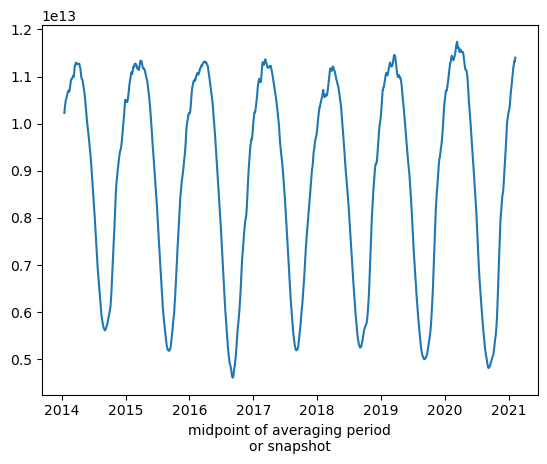

In [269]:
SIarea_total.plot()

### Time series of sea ice area in Beaufort Gyre

In [271]:
start_time = time.time()

rAc = sg.rAc.drop_vars(['XC','YC'])
# calculate total sea ice area through time. 
# ... note for some reason we have to drop XC and YC from the rAc grid cell area
SIarea_total_BG = (SIarea_DS.SIarea[:,200:400, 500:800]*rAc).sum(dim=['i','j']).compute()
print(f'total time : {(time.time() - start_time):.2f}')

total time : 12.44


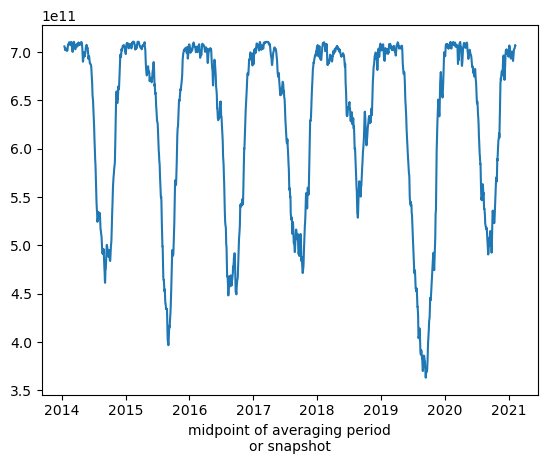

In [272]:
SIarea_total_BG.plot()

#### Look at 2019 and 2020 specifically

In [238]:
# find day with minimum ice in 2019 and 2020
min_day_2019 = SIarea_total_BG.sel(time=slice('2019-01-01', '2020-01-01')).argmin().values
min_day_2020 = SIarea_total_BG.sel(time=slice('2020-01-01', '2021-01-01')).argmin().values

print(min_day_2019, min_day_2020)


256 248


Text(0.5, 1.0, '2020 BG sea ice minimum')

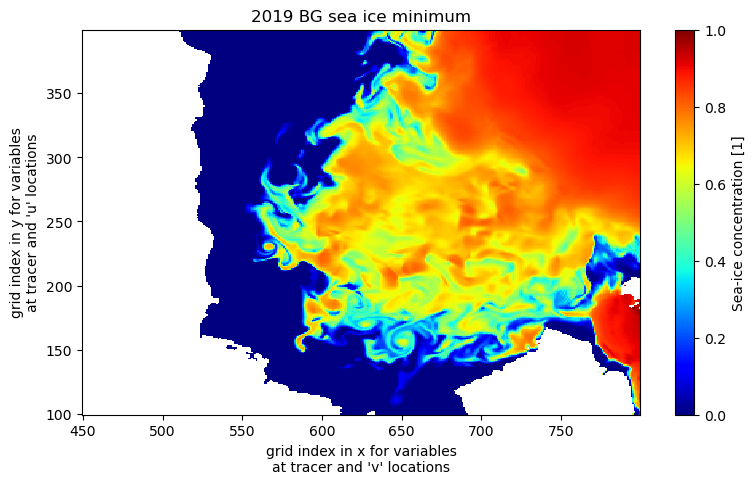

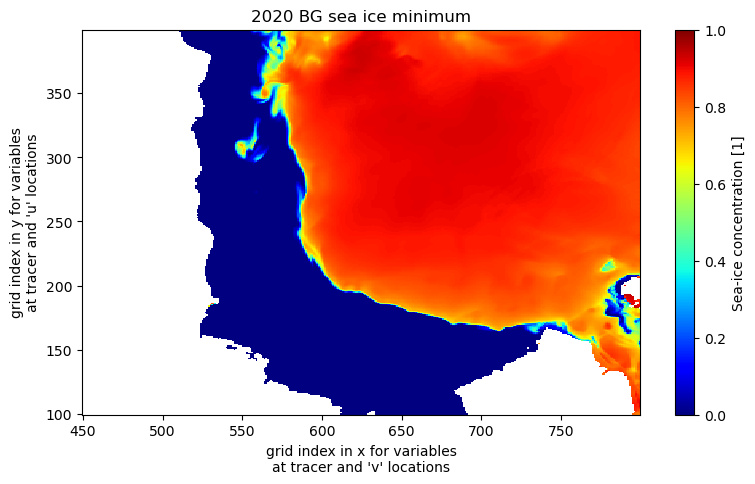

In [273]:
plt.figure(figsize=[9,5]);
ds2D.SIarea.sel(time=slice('2019-01-01', '2020-01-01'))[min_day_2019, 100:400, 450:800].plot(cmap='jet',vmin=0,vmax=1)
plt.title('2019 BG sea ice minimum')

plt.figure(figsize=[9,5]);
ds2D.SIarea.sel(time=slice('2020-01-01', '2021-01-01'))[min_day_2020, 100:400, 450:800].plot(cmap='jet',vmin=0,vmax=1)
plt.title('2020 BG sea ice minimum')

## 3D field

### Time series of OHC

In [242]:
# grid cell area 
# ... note for some reason we have to drop XC and YC from the rAc grid cell area
vol =  sg.rAc.drop_vars(['XC','YC'])*sg.drF
vol

<xarray.DataArray (j: 1080, i: 1800, k: 90)> Size: 1GB
array([[[3.51545618e+07, 4.00762004e+07, 4.57009303e+07, ...,
         1.40751834e+10, 1.54057836e+10, 1.68650495e+10],
        [3.50865995e+07, 3.99987234e+07, 4.56125793e+07, ...,
         1.40479727e+10, 1.53760005e+10, 1.68324452e+10],
        [3.50187171e+07, 3.99213375e+07, 4.55243323e+07, ...,
         1.40207940e+10, 1.53462524e+10, 1.67998794e+10],
        ...,
        [1.33027704e+07, 1.51651582e+07, 1.72936015e+07, ...,
         5.32616319e+09, 5.82967305e+09, 6.38187105e+09],
        [1.33619454e+07, 1.52326177e+07, 1.73705290e+07, ...,
         5.34985568e+09, 5.85560531e+09, 6.41025966e+09],
        [1.34210499e+07, 1.52999969e+07, 1.74473648e+07, ...,
         5.37351995e+09, 5.88150669e+09, 6.43861447e+09]],

       [[3.51545618e+07, 4.00762004e+07, 4.57009303e+07, ...,
         1.40751835e+10, 1.54057836e+10, 1.68650495e+10],
        [3.50865997e+07, 3.99987236e+07, 4.56125795e+07, ...,
         1.40479728e+10, 1.53760006e+10, 1.68324453e+10],
        [3.50187170e+07, 3.99213373e+07, 4.55243320e+07, ...,
         1.40207939e+10, 1.53462523e+10, 1.67998793e+10],
...
        [1.33031845e+07, 1.51656303e+07, 1.72941399e+07, ...,
         5.32632901e+09, 5.82985455e+09, 6.38206974e+09],
        [1.33623576e+07, 1.52330877e+07, 1.73710649e+07, ...,
         5.35002074e+09, 5.85578598e+09, 6.41045744e+09],
        [1.34214602e+07, 1.53004646e+07, 1.74478983e+07, ...,
         5.37368424e+09, 5.88168651e+09, 6.43881132e+09]],

       [[3.51545618e+07, 4.00762004e+07, 4.57009303e+07, ...,
         1.40751834e+10, 1.54057836e+10, 1.68650495e+10],
        [3.50865995e+07, 3.99987234e+07, 4.56125793e+07, ...,
         1.40479727e+10, 1.53760005e+10, 1.68324452e+10],
        [3.50187171e+07, 3.99213375e+07, 4.55243323e+07, ...,
         1.40207940e+10, 1.53462524e+10, 1.67998794e+10],
        ...,
        [1.33027704e+07, 1.51651582e+07, 1.72936015e+07, ...,
         5.32616319e+09, 5.82967305e+09, 6.38187105e+09],
        [1.33619454e+07, 1.52326177e+07, 1.73705290e+07, ...,
         5.34985568e+09, 5.85560531e+09, 6.41025966e+09],
        [1.34210499e+07, 1.52999969e+07, 1.74473648e+07, ...,
         5.37351995e+09, 5.88150669e+09, 6.43861447e+09]]])
Coordinates:
  * i        (i) int32 7kB 0 1 2 3 4 5 6 ... 1793 1794 1795 1796 1797 1798 1799
  * j        (j) int32 4kB 0 1 2 3 4 5 6 ... 1073 1074 1075 1076 1077 1078 1079
  * k        (k) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
    Z        (k) float32 360B -0.5 -1.57 -2.79 ... -6.301e+03 -6.76e+03

In [274]:
sg.Z[:10]

<xarray.DataArray 'Z' (k: 10)> Size: 40B
array([ -0.5  ,  -1.57 ,  -2.79 ,  -4.185,  -5.78 ,  -7.595,  -9.66 ,
       -12.01 , -14.68 , -17.705], dtype=float32)
Coordinates:
  * k        (k) int32 40B 0 1 2 3 4 5 6 7 8 9
    Z        (k) float32 40B -0.5 -1.57 -2.79 -4.185 ... -12.01 -14.68 -17.7
Attributes:
    long_name:              depth of tracer grid cell center
    units:                  m
    positive:               up
    bounds:                 Z_bnds
    comment:                Non-uniform vertical spacing.
    coverage_content_type:  coordinate
    standard_name:          depth

In [263]:
# calculate total sea ice area through time. 
start_time = time.time()
ohc_total_k0_10 = (THETA_DS.THETA[:,:10]*vol[:10]).sum(dim=['i','j','k']).compute()
print(f'total time : {(time.time() - start_time):.2f}')

total time : 92.02


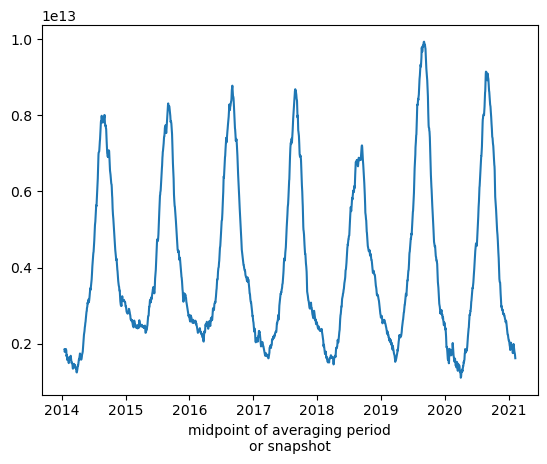

In [244]:
ohc_total_k0_10.plot()

In [254]:
vol.shape

(1080, 1800, 90)

In [261]:
# calculate total sea ice area through time. 
start_time = time.time()
ohc_bg_total_k0_10 = (THETA_DS.THETA[:, 0:10, 100:400, 450:800]*vol).sum(dim=['i','j','k']).compute()
print(f'total time : {(time.time() - start_time):.2f}')

total time : 53.11


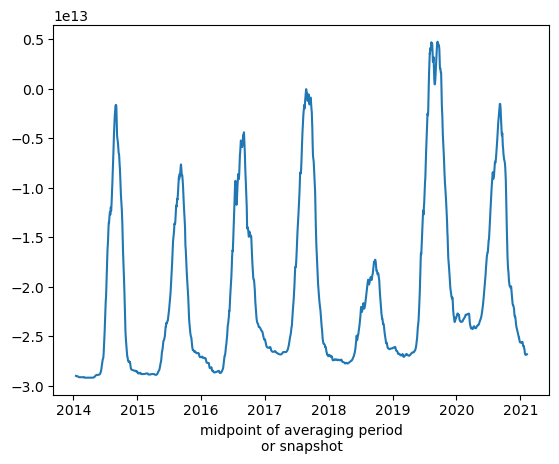

In [262]:
ohc_bg_total_k0_10.plot()